In [45]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertModel,  BertForSequenceClassification
from transformers import BertTokenizer, BertConfig
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
from module.util import seed_torch

PATH = './ckpt/article/0801_300limit_4epoch_binary_5.pkl'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 5
seed_torch(seed=seed)

In [46]:
all_df = pd.read_excel('data/article/train_augmented_1_v4.xlsx').fillna('')
# sentence_label_list = ['無標註', '自殺與憂鬱', '無助或無望', '正向文字', '其他負向文字', '生理反應或醫療狀況', '自殺行為']
# sentence_label_list = ['無標註','自殺與憂鬱','其他負向文字', '自殺行為']
sentence_label_list = ['無標註','自殺與憂鬱', '自殺行為', '其他類型']
X = []
y = []
for index, row in all_df.iterrows():
    a_X = []
    a_y = [0.0, 0.0]
    for key in all_df:
        if key in sentence_label_list:
            a_X.append(row[key])
    crisis_level = int(row['Crisis_Level'])
    if crisis_level == 0:
        y.append([1.0, 0.0])
    elif crisis_level == 1:
        y.append([1.0, 0.0])
    elif crisis_level == 2:
        y.append([1.0, 0.0])
    else:
        y.append([0.0, 1.0])
    X.append(a_X)
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(1427, 4)
(1427, 2)


In [47]:
print("y: ",np.sum(y, axis = 0))
print(X[0], y[0])

y:  [1127.  300.]
['' ' 可是我食慾不振 難聽一點就是他只把我當炮友。' ' 還會有自殘的行為 可是憂鬱症的症狀 我比較少 我不會失眠'
 ' 我想問問大家 我很常會突然心情不好 開始哭 無法停止'] [0. 1.]


In [48]:
limit = [300, 300]
count = [0]*2
partial_X = []
partial_y = []
for idx, y_ in enumerate(y):
    crisis_level = np.where(y_ == 1)[0][0]
    if count[crisis_level] < limit[crisis_level]:
        count[crisis_level] += 1
        partial_X.append(X[idx])
        partial_y.append(y_)
partial_X = np.array(partial_X)
partial_y = np.array(partial_y)
print(partial_X.shape)
print(partial_y.shape)

(600, 4)
(600, 2)


In [49]:
X_train, X_test, y_train, y_test = train_test_split(partial_X, partial_y, random_state=seed, train_size=0.9)
X_val_test = X_test
y_val_test = y_test
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, random_state=seed, train_size=0.5)
print(len(X_train), len(X_valid), len(X_test))
print("Distribution  0    1    2    3")
print("train: ",np.sum(y_train, axis = 0))
print("valid: ",np.sum(y_valid, axis = 0))
print("test:  ", np.sum(y_test, axis = 0))

540 30 30
Distribution  0    1    2    3
train:  [273. 267.]
valid:  [12. 18.]
test:   [15. 15.]


In [50]:
# model_name = 'bert-base-chinese'
model_name = 'hfl/chinese-bert-wwm-ext'
num_sentence_labels = len(sentence_label_list)
batch_size = 4
max_len = 512
train_epoch = 4
lr = 2e-5

class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, mode, max_len=max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.mode = mode
        self.max_len = max_len


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx].tolist()
        # print(type(text))
        # print(text)
        label = self.labels[idx]
        # if self.mode == 'test':
        #     label_tensor = None
        # else:
        label_tensor = torch.tensor(label)
        tokenized = self.tokenizer(text, padding='max_length', truncation="longest_first", return_tensors='pt', max_length=self.max_len)
        # tokenized = self.tokenizer(text, padding=512, truncation=True, return_tensors='pt')
        tokens_tensor = tokenized['input_ids']
        segments_tensor = tokenized['token_type_ids']
        mask_tensor = tokenized['attention_mask']
        
        # inputs = [inp for inp in inputs]
        # print(inputs)
        return (tokens_tensor, segments_tensor, mask_tensor, label_tensor)

class MyModel(BertPreTrainedModel):
    def __init__(self, config, num_labels ):
        super(MyModel, self).__init__(config)
        self.num_labels = num_labels
        self.embedding = []
        self.bert = BertModel(config)
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2, kernel_size=2))
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 4, kernel_size=2, stride=1, padding=1),
            torch.nn.BatchNorm2d(4),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2, kernel_size=2))
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(int(np.ceil(num_sentence_labels/4))*4*192, 2))
        self.nn1 = nn.Linear(num_sentence_labels*self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.nn2 = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.pooling_strategy = 'reduce_mean'
        self.class_weights = [1, 1]
        self.weights = torch.tensor(self.class_weights, dtype=torch.float)
    def forward(self, input_ids, token_type_ids=None, attention_mask=None,labels=None):
        for i in range(num_sentence_labels):
            a_kind_of_input_ids = input_ids[:, i, :]
            a_kind_of_token_type_ids = token_type_ids[:,i,:]
            a_kind_of_attention_mask = attention_mask[:,i,:]
            a_kind_of_embedding = self.bert(input_ids=a_kind_of_input_ids, token_type_ids=a_kind_of_token_type_ids,attention_mask=a_kind_of_attention_mask)
            encoder_hidden_states = a_kind_of_embedding.pooler_output.to(device)
            # print("encoder_hidden_states.shape:",encoder_hidden_states.shape)
            # if self.pooling_strategy == 'cls':
            #     cls_vector = encoder_hidden_states[:, 0, :]
            # elif self.pooling_strategy == 'reduce_mean':
            #     cls_vector = encoder_hidden_states.sum(axis=1) / attention_mask.sum(axis=-1).unsqueeze(-1)
            # print(cls_vector.shape)
            self.embedding.append(encoder_hidden_states)
        # concat_embedding = torch.cat(self.embedding, dim=1)
        concat_embedding = torch.stack(self.embedding).permute(1, 0, 2)
        to_shape = (concat_embedding.shape)
        concat_embedding = concat_embedding.reshape(to_shape[0], 1, to_shape[1], to_shape[2])
        self.embedding = []
        # print(concat_embedding.shape)
        # outputs = self.bert(input_ids, token_type_ids=token_type_ids,attention_mask=attention_mask)
        # outputs_concat = concat_embedding.reshape(-1,)
        
        # logits = self.nn1(concat_embedding)
        # logits = self.relu(logits)
        # logits = self.nn2(logits)
        logits = self.conv1(concat_embedding)
        logits = self.conv2(logits)
        to_shape_logits = logits.shape
        logits = logits.view(-1, to_shape_logits[1]*to_shape_logits[2]*to_shape_logits[3])
        logits = self.dense(logits)
        logits = self.softmax(logits)
        loss = None
        # print(logits.shape)
        # print(labels.shape)
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.weights.to(device))
            loss_ = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            loss = loss_
        # print(logits, loss)
        output = (logits,) # + outputs[2:]
        if loss is not None:
            return ((loss,) + output)
        else:
            return output
        # return loss, logits

In [51]:
tokenizer = BertTokenizer.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name)
config.max_length = max_len
model = MyModel(config, num_labels=2).to(device)

train_dataset = TextClassificationDataset(X_train, y_train, tokenizer, 'train')
val_dataset = TextClassificationDataset(X_valid, y_valid, tokenizer, 'valid')
test_dataset = TextClassificationDataset(X_test, y_test, tokenizer, 'test')
val_test_dataset = TextClassificationDataset(X_val_test, y_val_test, tokenizer, 'test')

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
val_test_dataloader = DataLoader(val_test_dataset, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=lr)

In [52]:
# Training
model.train()
for epoch in range(train_epoch):  # number of epochs
    print("epoch ", epoch+1)
    running_train_loss = 0.0
    running_train_correct = 0.0
    train_total = 0.0
    for batch_data in tqdm(train_dataloader):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in batch_data]
        optimizer.zero_grad()
        loss, logits = model(input_ids=tokens_tensors, token_type_ids=segments_tensors, attention_mask=masks_tensors,labels=labels)
        # print(loss)
        loss.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        running_train_loss += loss.item()
        prob = logits.data
        _, pred = torch.max(prob, 1)
        _, truth = torch.max(labels, 1)
        train_total += labels.size(0)
        running_train_correct += (pred == truth).sum().item()
        del tokens_tensors
        del segments_tensors
        del masks_tensors
        del labels
    train_acc = running_train_correct / train_total
    avg_running_train_loss = running_train_loss / len(train_dataloader)
    print('Train>>>[epoch %d] loss: %.3f, acc: %.3f' %
        (epoch + 1, avg_running_train_loss, train_acc))
    print("Validation: ")
    running_val_loss = 0.0
    running_val_correct = 0.0
    val_total = 0.0
    for batch_data in tqdm(val_dataloader):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in batch_data]
        with torch.no_grad(): 
            loss, logits = model(input_ids=tokens_tensors, token_type_ids=segments_tensors, attention_mask=masks_tensors,labels=labels)
            running_val_loss += loss.item()
            prob = logits.data
            _, pred = torch.max(prob, 1)
            _, truth = torch.max(labels, 1)
            val_total += labels.size(0)
            running_val_correct += (pred == truth).sum().item()
            del tokens_tensors
            del segments_tensors
            del masks_tensors
            del labels
    val_acc = running_val_correct / val_total
    avg_running_val_loss = running_val_loss / len(val_dataloader)
    print('Validation>>>[epoch %d] loss: %.3f, acc: %.3f' %
        (epoch + 1, avg_running_val_loss, val_acc))
        


epoch  1


100%|██████████| 135/135 [00:54<00:00,  2.48it/s]


Train>>>[epoch 1] loss: 0.502, acc: 0.806
Validation: 


100%|██████████| 15/15 [00:01<00:00, 12.90it/s]


Validation>>>[epoch 1] loss: 0.442, acc: 0.867
epoch  2


100%|██████████| 135/135 [00:54<00:00,  2.48it/s]


Train>>>[epoch 2] loss: 0.475, acc: 0.831
Validation: 


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


Validation>>>[epoch 2] loss: 0.426, acc: 0.933
epoch  3


100%|██████████| 135/135 [00:54<00:00,  2.48it/s]


Train>>>[epoch 3] loss: 0.474, acc: 0.828
Validation: 


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]


Validation>>>[epoch 3] loss: 0.428, acc: 0.867
epoch  4


100%|██████████| 135/135 [00:54<00:00,  2.48it/s]


Train>>>[epoch 4] loss: 0.470, acc: 0.835
Validation: 


100%|██████████| 15/15 [00:01<00:00, 12.88it/s]

Validation>>>[epoch 4] loss: 0.421, acc: 0.867


In [53]:

y_true = []
y_pred = []
train_total = 0.0
for batch_data in tqdm(test_dataloader):
    tokens_tensors, segments_tensors, masks_tensors,labels  = [t.to(device) for t in batch_data]
    with torch.no_grad(): 
        loss, logits = model(input_ids=tokens_tensors, token_type_ids=segments_tensors, attention_mask=masks_tensors,labels=labels)
    # print(loss)
        prob = logits.data
        _, pred = torch.max(prob, 1)
        _, truth = torch.max(labels, 1)
        train_total += labels.size(0)
        y_true.append(truth)
        y_pred.append(pred)
        del tokens_tensors
        del segments_tensors
        del masks_tensors
        del labels
pred = torch.cat(y_pred)
ground_truth = torch.cat(y_true)
print(pred.shape)
print(ground_truth.shape)


100%|██████████| 8/8 [00:01<00:00,  7.15it/s]

torch.Size([30])
torch.Size([30])


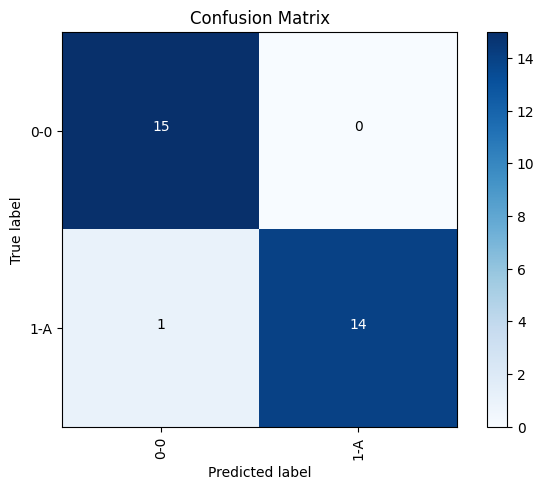

accuracy:  0.967
f1-score:  0.967


In [54]:
cm = confusion_matrix(y_true=ground_truth.cpu(), y_pred=pred.cpu(), labels=[0,1])
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0-0','1-A'], rotation=90)
plt.yticks(tick_marks, ['0-0','1-A'])

fmt = 'd' 
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
acc = accuracy_score(y_true=ground_truth.cpu(), y_pred=pred.cpu())
f1 = f1_score(y_true=ground_truth.cpu(), y_pred=pred.cpu(), average='weighted')
print("accuracy: ", round(acc, 3))
print("f1-score: ", round(f1, 3))

In [55]:
# print(

torch.save(model.state_dict(), PATH)